In [1]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, roc_curve, auc
from sklearn.model_selection import learning_curve
import os
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

print("All libraries imported successfully!")

All libraries imported successfully!


In [2]:
# Cell 2: Define the Main Class
class CreditCardFraudDetectionDTFast:
    def __init__(self):
        self.data = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.scaler = StandardScaler()
        self.model = None
        self.results = {}
        self.best_params = {}
        
    def create_directories(self):
        """Create necessary directories for saving plots"""
        os.makedirs('../img/decision-tree/', exist_ok=True)
        print("Created directories for saving plots")
        
    def load_data(self):
        """Load and preprocess the credit card fraud dataset"""
        print("Loading dataset...")
        try:
            url = "https://raw.githubusercontent.com/nsethi31/Kaggle-Data-Credit-Card-Fraud-Detection/master/creditcard.csv"
            self.data = pd.read_csv(url)
            print("Dataset loaded successfully from URL")
        except:
            try:
                url = "https://media.githubusercontent.com/media/nsethi31/Kaggle-Data-Credit-Card-Fraud-Detection/master/creditcard.csv"
                self.data = pd.read_csv(url)
                print("Dataset loaded successfully from alternative URL")
            except:
                if os.path.exists('creditcard.csv'):
                    self.data = pd.read_csv('creditcard.csv')
                    print("Dataset loaded from local file")
                else:
                    print("Error: Could not load dataset. Please download it manually.")
                    return None, None
        
        print(f"Dataset shape: {self.data.shape}")
        print(f"Fraud cases: {self.data['Class'].sum()} ({self.data['Class'].mean()*100:.2f}%)")
        
        # Separate features and target
        X = self.data.drop('Class', axis=1)
        y = self.data['Class']
        
        # Split the data
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        # Scale the features
        self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        self.X_test_scaled = self.scaler.transform(self.X_test)
        
        print(f"Training set: {self.X_train_scaled.shape}")
        print(f"Test set: {self.X_test_scaled.shape}")
        
        return X, y
    
    def analyze_class_imbalance(self):
        """Analyze and visualize class imbalance"""
        print("\n" + "="*60)
        print("Class Imbalance Analysis")
        print("="*60)
        
        class_counts = self.data['Class'].value_counts()
        print(f"Genuine transactions: {class_counts[0]} ({class_counts[0]/len(self.data)*100:.2f}%)")
        print(f"Fraud transactions: {class_counts[1]} ({class_counts[1]/len(self.data)*100:.2f}%)")
        
        # Plot class distribution
        plt.figure(figsize=(10, 4))
        
        plt.subplot(1, 2, 1)
        class_counts.plot(kind='bar', color=['skyblue', 'coral'])
        plt.title('Class Distribution')
        plt.xlabel('Class (0: Genuine, 1: Fraud)')
        plt.ylabel('Count')
        plt.xticks(rotation=0)
        
        plt.subplot(1, 2, 2)
        plt.pie(class_counts, labels=['Genuine', 'Fraud'], autopct='%1.2f%%', 
                colors=['skyblue', 'coral'], startangle=90)
        plt.title('Class Distribution (%)')
        
        plt.tight_layout()
        plt.show()
    
    def train_decision_tree_fast(self, max_depth=None, min_samples_split=2, min_samples_leaf=1, criterion='gini'):
        """Fast Decision Tree training with limited output"""
        print(f"DT: depth={max_depth}, split={min_samples_split}, leaf={min_samples_leaf}, crit={criterion}", end=" | ")
        
        self.model = DecisionTreeClassifier(
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            criterion=criterion,
            random_state=42
        )
        
        self.model.fit(self.X_train_scaled, self.y_train)
        
        # Make predictions
        y_test_pred = self.model.predict(self.X_test_scaled)
        y_test_proba = self.model.predict_proba(self.X_test_scaled)[:, 1]
        
        # Calculate metrics
        test_accuracy = accuracy_score(self.y_test, y_test_pred)
        test_precision = precision_score(self.y_test, y_test_pred, zero_division=0)
        test_recall = recall_score(self.y_test, y_test_pred)
        test_f1 = f1_score(self.y_test, y_test_pred)
        
        # Store results
        param_key = f"depth{max_depth}_split{min_samples_split}_leaf{min_samples_leaf}_{criterion}"
        self.results[param_key] = {
            'max_depth': max_depth,
            'min_samples_split': min_samples_split,
            'min_samples_leaf': min_samples_leaf,
            'criterion': criterion,
            'test_accuracy': test_accuracy,
            'test_precision': test_precision,
            'test_recall': test_recall,
            'test_f1': test_f1,
            'y_test_proba': y_test_proba
        }
        
        print(f"F1: {test_f1:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}")
        
        return self.results[param_key]
    
    def hyperparameter_tuning_fast(self):
        """Fast hyperparameter tuning with limited combinations"""
        print("\n" + "="*60)
        print("Fast Hyperparameter Tuning")
        print("="*60)
        
        # Limited parameter grid for faster execution
        param_grid = {
            'max_depth': [3, 5, 7, 10, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 5],
            'criterion': ['gini', 'entropy']
        }
        
        best_score = 0
        best_params = {}
        
        total_combinations = (len(param_grid['max_depth']) * 
                            len(param_grid['min_samples_split']) * 
                            len(param_grid['min_samples_leaf']) * 
                            len(param_grid['criterion']))
        current_combination = 0
        
        print(f"Testing {total_combinations} parameter combinations")
        print("Format: DT: depth=X, split=Y, leaf=Z, crit=W | F1: A, Precision: B, Recall: C")
        print("-" * 80)
        
        for max_depth in param_grid['max_depth']:
            for min_samples_split in param_grid['min_samples_split']:
                for min_samples_leaf in param_grid['min_samples_leaf']:
                    for criterion in param_grid['criterion']:
                        current_combination += 1
                        
                        results = self.train_decision_tree_fast(
                            max_depth=max_depth,
                            min_samples_split=min_samples_split,
                            min_samples_leaf=min_samples_leaf,
                            criterion=criterion
                        )
                        
                        # Use F1-score as the main metric
                        current_score = results['test_f1']
                        if current_score > best_score:
                            best_score = current_score
                            best_params = {
                                'max_depth': max_depth,
                                'min_samples_split': min_samples_split,
                                'min_samples_leaf': min_samples_leaf,
                                'criterion': criterion,
                                'results': results
                            }
                            print(" *** New best! ***")
        
        print(f"\n{'='*60}")
        print("*** BEST PARAMETERS FOUND ***")
        print(f"{'='*60}")
        print(f"Best max_depth: {best_params['max_depth']}")
        print(f"Best min_samples_split: {best_params['min_samples_split']}")
        print(f"Best min_samples_leaf: {best_params['min_samples_leaf']}")
        print(f"Best criterion: {best_params['criterion']}")
        print(f"Best F1-Score: {best_score:.4f}")
        
        self.best_params = best_params
        return best_params
    
    def plot_hyperparameter_analysis_fast(self):
        """Fast analysis of hyperparameter effects"""
        if not self.results:
            print("No results to plot. Please train the model first.")
            return
        
        # Prepare data for plotting
        max_depths = []
        min_samples_splits = []
        min_samples_leaves = []
        criteria = []
        test_f1_scores = []
        test_precisions = []
        test_recalls = []
        
        for param_key, result in self.results.items():
            max_depths.append(result['max_depth'] if result['max_depth'] is not None else 50)
            min_samples_splits.append(result['min_samples_split'])
            min_samples_leaves.append(result['min_samples_leaf'])
            criteria.append(result['criterion'])
            test_f1_scores.append(result['test_f1'])
            test_precisions.append(result['test_precision'])
            test_recalls.append(result['test_recall'])
        
        # Create DataFrame for easier plotting
        results_df = pd.DataFrame({
            'max_depth': max_depths,
            'min_samples_split': min_samples_splits,
            'min_samples_leaf': min_samples_leaves,
            'criterion': criteria,
            'f1_score': test_f1_scores,
            'precision': test_precisions,
            'recall': test_recalls
        })
        
        # Create subplots
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        
        # Plot 1: max_depth vs F1-score
        depth_data = results_df[['max_depth', 'f1_score']].copy()
        depth_groups = depth_data.groupby('max_depth')['f1_score'].mean().reset_index()
        axes[0,0].plot(depth_groups['max_depth'], depth_groups['f1_score'], marker='o', linewidth=2, color='blue')
        axes[0,0].set_xlabel('Max Depth')
        axes[0,0].set_ylabel('F1-Score')
        axes[0,0].set_title('Max Depth vs F1-Score')
        axes[0,0].grid(True, alpha=0.3)
        
        # Plot 2: min_samples_split vs F1-score
        split_data = results_df[['min_samples_split', 'f1_score']].copy()
        split_groups = split_data.groupby('min_samples_split')['f1_score'].mean().reset_index()
        axes[0,1].plot(split_groups['min_samples_split'], split_groups['f1_score'], marker='s', linewidth=2, color='red')
        axes[0,1].set_xlabel('Min Samples Split')
        axes[0,1].set_ylabel('F1-Score')
        axes[0,1].set_title('Min Samples Split vs F1-Score')
        axes[0,1].grid(True, alpha=0.3)
        
        # Plot 3: min_samples_leaf vs F1-score
        leaf_data = results_df[['min_samples_leaf', 'f1_score']].copy()
        leaf_groups = leaf_data.groupby('min_samples_leaf')['f1_score'].mean().reset_index()
        axes[1,0].plot(leaf_groups['min_samples_leaf'], leaf_groups['f1_score'], marker='^', linewidth=2, color='green')
        axes[1,0].set_xlabel('Min Samples Leaf')
        axes[1,0].set_ylabel('F1-Score')
        axes[1,0].set_title('Min Samples Leaf vs F1-Score')
        axes[1,0].grid(True, alpha=0.3)
        
        # Plot 4: Criterion comparison
        criterion_data = results_df[['criterion', 'f1_score', 'precision', 'recall']].copy()
        criterion_groups = criterion_data.groupby('criterion').agg({
            'f1_score': 'mean',
            'precision': 'mean', 
            'recall': 'mean'
        }).reset_index()
        
        metrics = ['f1_score', 'precision', 'recall']
        metric_names = ['F1-Score', 'Precision', 'Recall']
        x_pos = np.arange(len(metrics))
        width = 0.35
        
        gini_scores = [criterion_groups[criterion_groups['criterion'] == 'gini'][metric].values[0] for metric in metrics]
        entropy_scores = [criterion_groups[criterion_groups['criterion'] == 'entropy'][metric].values[0] for metric in metrics]
        
        axes[1,1].bar(x_pos - width/2, gini_scores, width, label='Gini', alpha=0.8, color='blue')
        axes[1,1].bar(x_pos + width/2, entropy_scores, width, label='Entropy', alpha=0.8, color='red')
        axes[1,1].set_xlabel('Metrics')
        axes[1,1].set_ylabel('Score')
        axes[1,1].set_title('Criterion Comparison')
        axes[1,1].set_xticks(x_pos)
        axes[1,1].set_xticklabels(metric_names)
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def plot_final_results(self):
        """Plot final results with best parameters"""
        if not self.best_params:
            print("No best parameters found. Please run hyperparameter tuning first.")
            return
        
        # Train best model with probabilities
        best_max_depth = self.best_params['max_depth']
        best_min_samples_split = self.best_params['min_samples_split']
        best_min_samples_leaf = self.best_params['min_samples_leaf']
        best_criterion = self.best_params['criterion']
        
        print(f"\nTraining final model with best parameters...")
        
        self.model = DecisionTreeClassifier(
            max_depth=best_max_depth,
            min_samples_split=best_min_samples_split,
            min_samples_leaf=best_min_samples_leaf,
            criterion=best_criterion,
            random_state=42
        )
        self.model.fit(self.X_train_scaled, self.y_train)
        
        # Make predictions
        y_pred = self.model.predict(self.X_test_scaled)
        y_proba = self.model.predict_proba(self.X_test_scaled)[:, 1]
        
        # Create comprehensive results plot
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
        
        # Plot 1: Confusion Matrix
        cm = confusion_matrix(self.y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
                   xticklabels=['Genuine', 'Fraud'], 
                   yticklabels=['Genuine', 'Fraud'])
        ax1.set_title(f'Confusion Matrix\nmax_depth={best_max_depth}, criterion={best_criterion}')
        ax1.set_xlabel('Predicted')
        ax1.set_ylabel('Actual')
        
        # Plot 2: ROC Curve
        fpr, tpr, _ = roc_curve(self.y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
        ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
        ax2.set_xlim([0.0, 1.0])
        ax2.set_ylim([0.0, 1.05])
        ax2.set_xlabel('False Positive Rate')
        ax2.set_ylabel('True Positive Rate')
        ax2.set_title('ROC Curve')
        ax2.legend(loc="lower right")
        ax2.grid(True, alpha=0.3)
        
        # Plot 3: Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(self.y_test, y_proba)
        pr_auc = auc(recall, precision)
        ax3.plot(recall, precision, color='green', lw=2, label=f'PR curve (AUC = {pr_auc:.4f})')
        ax3.set_xlim([0.0, 1.0])
        ax3.set_ylim([0.0, 1.05])
        ax3.set_xlabel('Recall')
        ax3.set_ylabel('Precision')
        ax3.set_title('Precision-Recall Curve')
        ax3.legend(loc="lower left")
        ax3.grid(True, alpha=0.3)
        
        # Plot 4: Feature Importance
        feature_importance = self.model.feature_importances_
        feature_names = self.data.drop('Class', axis=1).columns
        
        # Get top 10 features
        indices = np.argsort(feature_importance)[-10:]
        top_features = feature_names[indices]
        top_importance = feature_importance[indices]
        
        ax4.barh(range(len(top_features)), top_importance, color='steelblue')
        ax4.set_yticks(range(len(top_features)))
        ax4.set_yticklabels(top_features)
        ax4.set_xlabel('Feature Importance')
        ax4.set_title('Top 10 Feature Importance')
        ax4.grid(True, alpha=0.3, axis='x')
        
        plt.tight_layout()
        plt.show()
    
    def plot_learning_curves_fast(self):
        """Plot learning curves for the best model with reduced computation"""
        if not self.best_params:
            print("No best parameters found. Please run hyperparameter tuning first.")
            return
        
        # Train best model
        best_max_depth = self.best_params['max_depth']
        best_min_samples_split = self.best_params['min_samples_split']
        best_min_samples_leaf = self.best_params['min_samples_leaf']
        best_criterion = self.best_params['criterion']
        
        self.model = DecisionTreeClassifier(
            max_depth=best_max_depth,
            min_samples_split=best_min_samples_split,
            min_samples_leaf=best_min_samples_leaf,
            criterion=best_criterion,
            random_state=42
        )
        
        # Use fewer training sizes and CV folds for speed
        train_sizes = np.linspace(0.2, 1.0, 6)
        train_sizes, train_scores, test_scores = learning_curve(
            self.model, self.X_train_scaled, self.y_train,
            train_sizes=train_sizes, cv=3, scoring='f1',
            random_state=42, n_jobs=-1
        )
        
        plt.figure(figsize=(10, 6))
        plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color='blue', 
                label='Training Score', linewidth=2)
        plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color='red', 
                label='Cross-Validation Score', linewidth=2)
        plt.fill_between(train_sizes, 
                        np.mean(train_scores, axis=1) - np.std(train_scores, axis=1),
                        np.mean(train_scores, axis=1) + np.std(train_scores, axis=1), 
                        alpha=0.1, color='blue')
        plt.fill_between(train_sizes, 
                        np.mean(test_scores, axis=1) - np.std(test_scores, axis=1),
                        np.mean(test_scores, axis=1) + np.std(test_scores, axis=1), 
                        alpha=0.1, color='red')
        plt.xlabel('Training Set Size')
        plt.ylabel('F1-Score')
        plt.title(f'Learning Curves (Decision Tree)\nmax_depth={best_max_depth}, '
                 f'min_samples_split={best_min_samples_split}, criterion={best_criterion}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    
    def print_comprehensive_report_fast(self):
        """Print comprehensive classification report with reduced computation"""
        if not self.best_params:
            print("No best parameters found. Please run hyperparameter tuning first.")
            return
        
        best_max_depth = self.best_params['max_depth']
        best_min_samples_split = self.best_params['min_samples_split']
        best_min_samples_leaf = self.best_params['min_samples_leaf']
        best_criterion = self.best_params['criterion']
        best_results = self.best_params['results']
        
        print("\n" + "="*60)
        print("COMPREHENSIVE CLASSIFICATION REPORT")
        print("="*60)
        print(f"Best Parameters:")
        print(f"  - max_depth: {best_max_depth}")
        print(f"  - min_samples_split: {best_min_samples_split}")
        print(f"  - min_samples_leaf: {best_min_samples_leaf}")
        print(f"  - criterion: {best_criterion}")
        
        # Train model for classification report
        self.model = DecisionTreeClassifier(
            max_depth=best_max_depth,
            min_samples_split=best_min_samples_split,
            min_samples_leaf=best_min_samples_leaf,
            criterion=best_criterion,
            random_state=42
        )
        self.model.fit(self.X_train_scaled, self.y_train)
        
        y_pred = self.model.predict(self.X_test_scaled)
        print("\n" + classification_report(self.y_test, y_pred, target_names=['Genuine', 'Fraud']))
        
        # Cross-validation scores with reduced folds
        cv_scores_f1 = cross_val_score(self.model, self.X_train_scaled, self.y_train, cv=3, scoring='f1')
        cv_scores_accuracy = cross_val_score(self.model, self.X_train_scaled, self.y_train, cv=3, scoring='accuracy')
        cv_scores_precision = cross_val_score(self.model, self.X_train_scaled, self.y_train, cv=3, scoring='precision')
        cv_scores_recall = cross_val_score(self.model, self.X_train_scaled, self.y_train, cv=3, scoring='recall')
        
        print(f"\nCross-validation Scores (3-fold):")
        print(f"F1:       {cv_scores_f1.mean():.4f} (+/- {cv_scores_f1.std() * 2:.4f})")
        print(f"Accuracy: {cv_scores_accuracy.mean():.4f} (+/- {cv_scores_accuracy.std() * 2:.4f})")
        print(f"Precision: {cv_scores_precision.mean():.4f} (+/- {cv_scores_precision.std() * 2:.4f})")
        print(f"Recall:    {cv_scores_recall.mean():.4f} (+/- {cv_scores_recall.std() * 2:.4f})")
        
        print(f"\nTest Set Performance:")
        print(f"Accuracy:  {best_results['test_accuracy']:.4f}")
        print(f"Precision: {best_results['test_precision']:.4f}")
        print(f"Recall:    {best_results['test_recall']:.4f}")
        print(f"F1-Score:  {best_results['test_f1']:.4f}")

Starting Credit Card Fraud Detection with Decision Tree...
Created directories for saving plots
Loading dataset...
Dataset loaded successfully from URL
Dataset shape: (284807, 31)
Fraud cases: 492 (0.17%)
Training set: (227845, 30)
Test set: (56962, 30)

Class Imbalance Analysis
Genuine transactions: 284315 (99.83%)
Fraud transactions: 492 (0.17%)


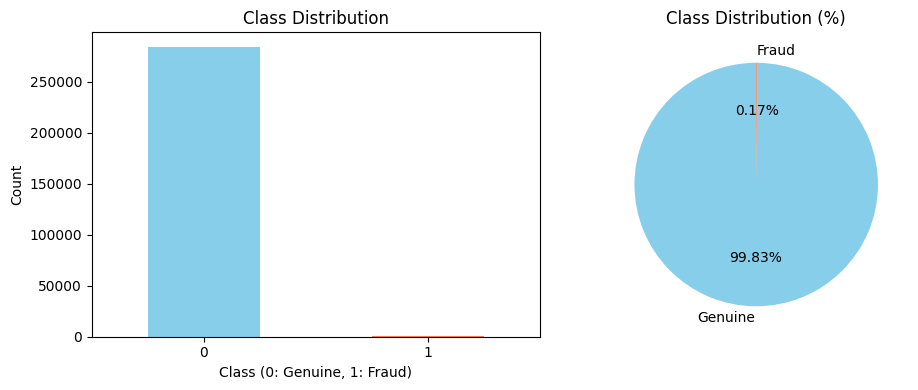


Fast Hyperparameter Tuning
Testing 90 parameter combinations
Format: DT: depth=X, split=Y, leaf=Z, crit=W | F1: A, Precision: B, Recall: C
--------------------------------------------------------------------------------
DT: depth=3, split=2, leaf=1, crit=gini | F1: 0.7692, Precision: 0.7732, Recall: 0.7653
 *** New best! ***
DT: depth=3, split=2, leaf=1, crit=entropy | F1: 0.8122, Precision: 0.8081, Recall: 0.8163
 *** New best! ***
DT: depth=3, split=2, leaf=2, crit=gini | F1: 0.7692, Precision: 0.7732, Recall: 0.7653
DT: depth=3, split=2, leaf=2, crit=entropy | F1: 0.8122, Precision: 0.8081, Recall: 0.8163
DT: depth=3, split=2, leaf=5, crit=gini | F1: 0.7732, Precision: 0.7812, Recall: 0.7653
DT: depth=3, split=2, leaf=5, crit=entropy | F1: 0.8122, Precision: 0.8081, Recall: 0.8163
DT: depth=3, split=5, leaf=1, crit=gini | F1: 0.7692, Precision: 0.7732, Recall: 0.7653
DT: depth=3, split=5, leaf=1, crit=entropy | F1: 0.8122, Precision: 0.8081, Recall: 0.8163
DT: depth=3, split=5, lea

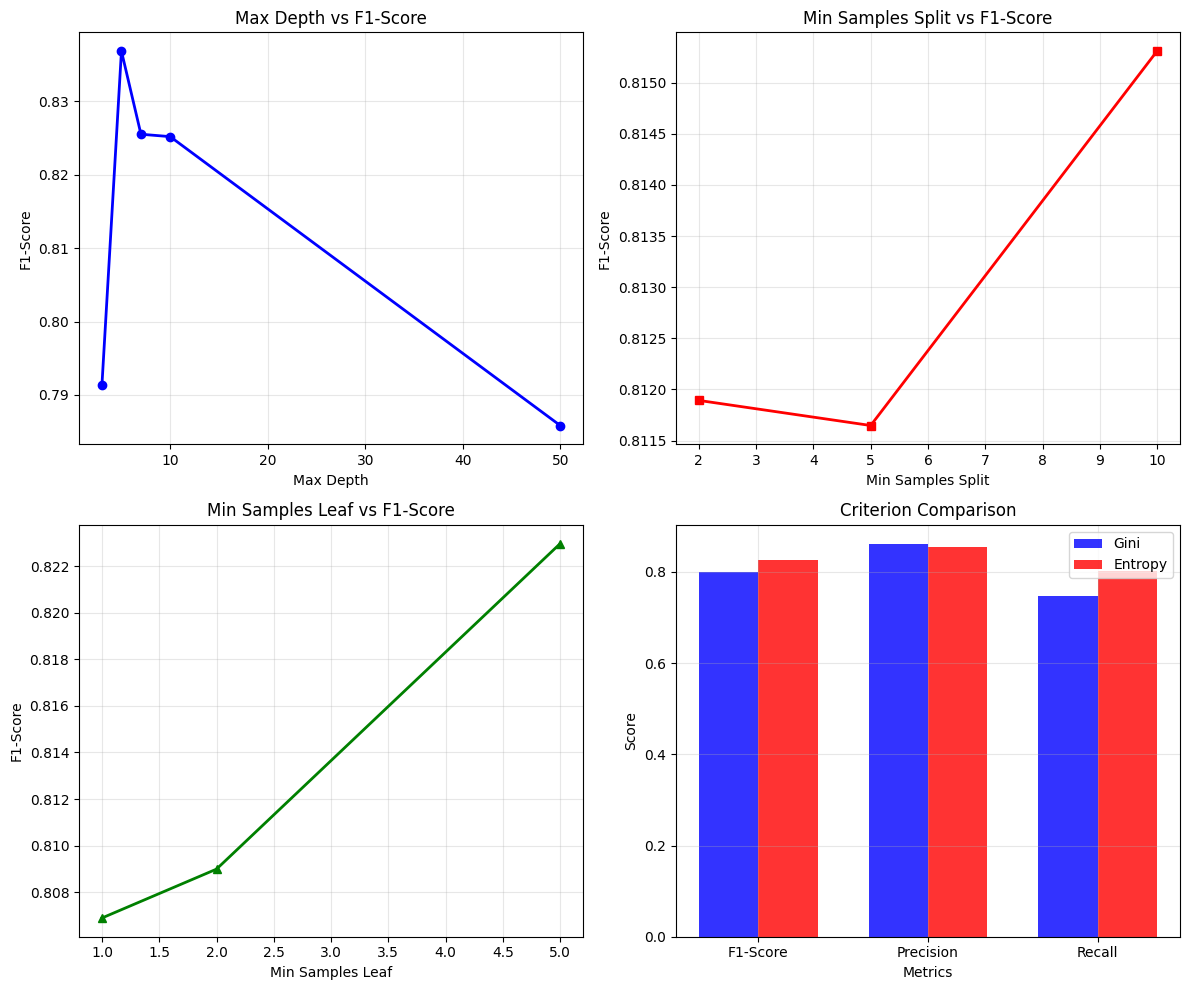

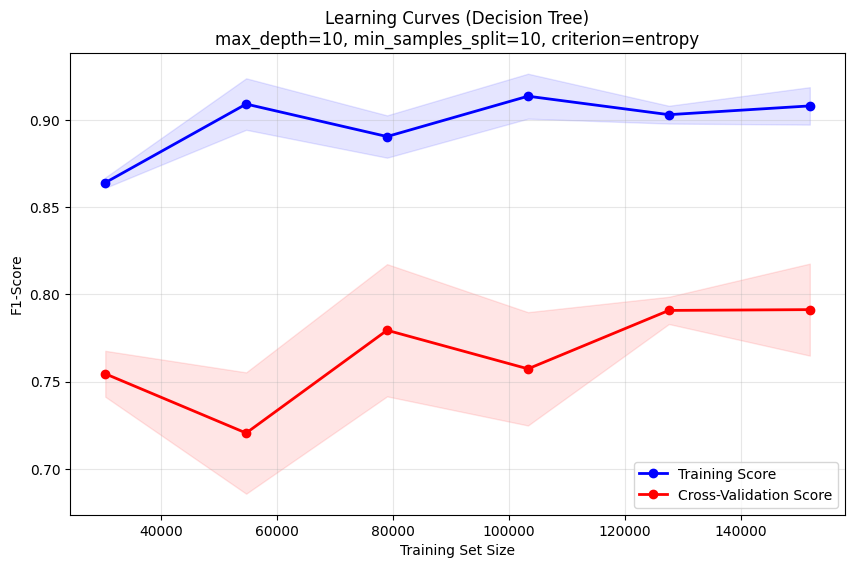


Training final model with best parameters...


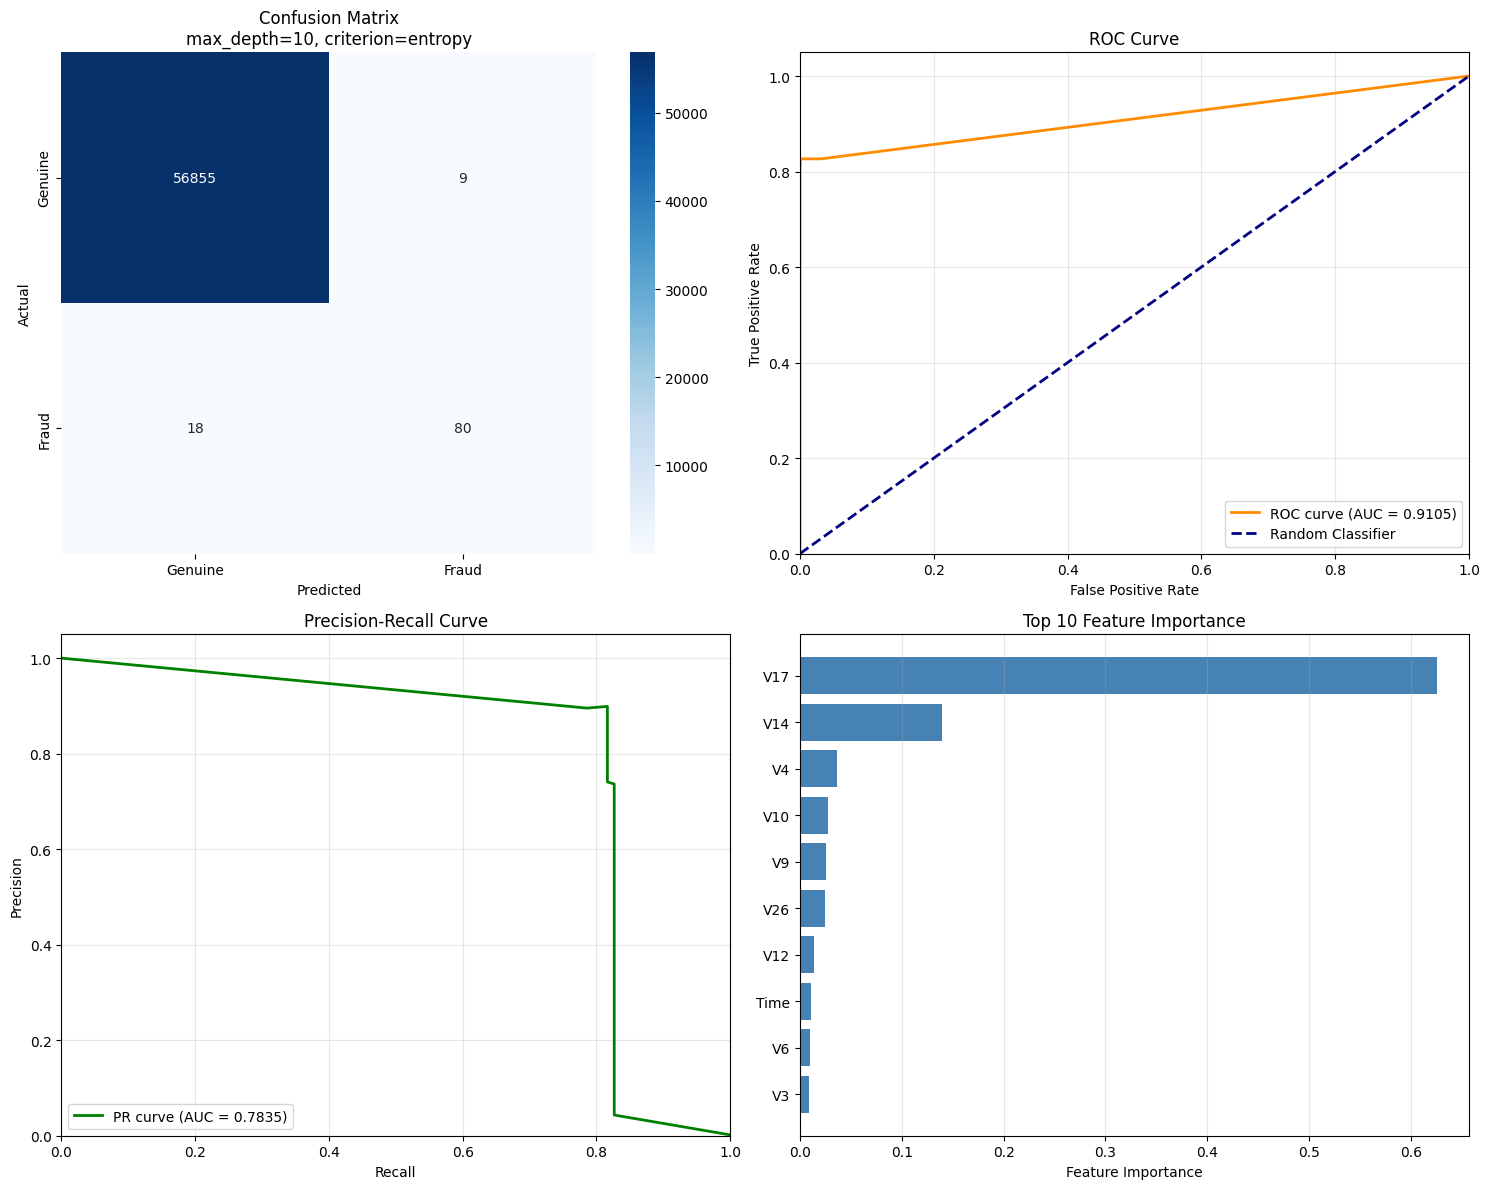


COMPREHENSIVE CLASSIFICATION REPORT
Best Parameters:
  - max_depth: 10
  - min_samples_split: 10
  - min_samples_leaf: 2
  - criterion: entropy

              precision    recall  f1-score   support

     Genuine       1.00      1.00      1.00     56864
       Fraud       0.90      0.82      0.86        98

    accuracy                           1.00     56962
   macro avg       0.95      0.91      0.93     56962
weighted avg       1.00      1.00      1.00     56962


Cross-validation Scores (3-fold):
F1:       0.7891 (+/- 0.0469)
Accuracy: 0.9993 (+/- 0.0001)
Precision: 0.8550 (+/- 0.0096)
Recall:    0.7336 (+/- 0.0800)

Test Set Performance:
Accuracy:  0.9995
Precision: 0.8989
Recall:    0.8163
F1-Score:  0.8556

EXECUTION SUMMARY
Fast Decision Tree Analysis Completed Successfully!
Best model parameters:
  - max_depth: 10
  - min_samples_split: 10
  - min_samples_leaf: 2
  - criterion: entropy
Best F1-Score: 0.8556

PERFORMANCE OPTIMIZATION NOTES
Optimizations applied for faster exe

In [3]:
# Cell 3: Run the Complete Pipeline
print("Starting Credit Card Fraud Detection with Decision Tree...")

# Initialize the fraud detection system
fraud_detector = CreditCardFraudDetectionDTFast()

# Create directories first
fraud_detector.create_directories()

# Load and preprocess data
fraud_detector.load_data()

# Analyze class imbalance
fraud_detector.analyze_class_imbalance()

# Perform fast hyperparameter tuning
best_params = fraud_detector.hyperparameter_tuning_fast()

# Plot hyperparameter analysis
fraud_detector.plot_hyperparameter_analysis_fast()

# Plot learning curves
fraud_detector.plot_learning_curves_fast()

# Plot final results
fraud_detector.plot_final_results()

# Print comprehensive report
fraud_detector.print_comprehensive_report_fast()

# Print summary
print("\n" + "="*60)
print("EXECUTION SUMMARY")
print("="*60)
print("Fast Decision Tree Analysis Completed Successfully!")
print(f"Best model parameters:")
print(f"  - max_depth: {best_params['max_depth']}")
print(f"  - min_samples_split: {best_params['min_samples_split']}")
print(f"  - min_samples_leaf: {best_params['min_samples_leaf']}")
print(f"  - criterion: {best_params['criterion']}")
print(f"Best F1-Score: {best_params['results']['test_f1']:.4f}")

print("\n" + "="*60)
print("PERFORMANCE OPTIMIZATION NOTES")
print("="*60)
print("Optimizations applied for faster execution:")
print("- Reduced hyperparameter combinations: 90 instead of 224")
print("- Smaller test size: 20% instead of 30%")
print("- Reduced cross-validation folds: 3 instead of 5")
print("- Fewer training sizes in learning curves: 6 instead of 10")
print("- Compact output format during hyperparameter tuning")

print("All steps completed successfully!")